In [1]:
import rdkit as rdkit
import pandas as pd
import numpy as np
from rdkit import rdBase
from rdkit import Chem
from rdkit import RDConfig

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import PandasTools
import os

import deepchem as dc

In [2]:
# для продолжения  работы
sdfFile = os.path.join(RDConfig.RDDataDir,'C:/Users/Диана/Jupyter_files/scams_filt.sdf')
scams_filt = PandasTools.LoadSDF(sdfFile,smilesName='Smiles String',molColName='Molecule', includeFingerprints=False)

sdfFile = os.path.join(RDConfig.RDDataDir,'C:/Users/Диана/Jupyter_files/test_set.sdf')
test_set = PandasTools.LoadSDF(sdfFile,smilesName='Smiles String',molColName='Molecule', includeFingerprints=False)

In [ ]:
# agg? начения сделать int

scams_filt['agg?'] = scams_filt['agg?'].apply(lambda x: int(x))
test_set['agg?'] = test_set['agg?'].apply(lambda x: int(x))

In [ ]:
# сделать sdf файлы на будущее
PandasTools.WriteSDF(scams_filt, 'scams_filt.sdf', molColName='Molecule', properties=list(scams_filt.columns))

In [ ]:
PandasTools.WriteSDF(test_set, 'test_set.sdf', molColName='Molecule', properties=list(test_set.columns))

### Дескрипторы RDKit

In [ ]:
from rdkit.Chem import Descriptors

In [ ]:
#альтернатива 2
# сделать класс включающий все дескрипторы 
#from rdkit.Chem import rdMolDescriptors
#descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

#get_descriptors = rdMolDescriptors.Properties(descriptor_names)
#def smi_to_descriptors(smile):
    #mol = Chem.MolFromSmiles(smile)
    #descriptors = []
    #if mol:
        #descriptors = np.array(get_descriptors.ComputeProperties(mol))
    #return descriptors


In [ ]:
def smi_to_descriptors(smile):
    featurizer = dc.feat.RDKitDescriptors()
    features = featurizer.featurize(smile)
    return features


In [ ]:
# пименить функция к столбцу smiles
train_rdkit_desc_series = scams_filt['Smiles String'].apply(smi_to_descriptors)
test_rdkit_desc_series = test_set['Smiles String'].apply(smi_to_descriptors)

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html функия apply в пандасе

### Датасет в pandas

In [ ]:
# сделать датафрейм

train_rdkit_desc_df =  pd.DataFrame(train_rdkit_desc_series.map(lambda x: x[0]).tolist())
test_rdkit_desc_df = pd.DataFrame(test_rdkit_desc_series.map(lambda x: x[0]).tolist())

In [ ]:
# ответы
train_y = scams_filt['agg?']
test_y = test_set['agg?']

In [ ]:
# x  и y в одном блоке
train_rdkit_desc_xy = pd.concat([train_rdkit_desc_df, train_y], axis=1)
test_rdkit_desc_xy = pd.concat([test_rdkit_desc_df, test_y], axis=1)

In [ ]:
# сохранить
train_rdkit_desc_df.to_csv('train_rdkit_desc_df.csv')
test_rdkit_desc_df.to_csv('test_rdkit_desc_df.csv')
train_y.to_csv('train_y.csv')
test_y.to_csv('test_y.csv')
train_rdkit_desc_xy.to_csv('train_rdkit_desc_xy.csv')
test_rdkit_desc_xy.to_csv('test_rdkit_desc_xy1.csv')

### Numpy датасет

In [ ]:
# тут было преобразование в np.array  но удалилось

# сохранить
np.savetxt("train_rdkit_desc_np.csv", train_rdkit_desc_np, delimiter=",")
np.savetxt("test_rdkit_desc_np.csv", test_rdkit_desc_np, delimiter=",")

np.savetxt("train_y_np.csv", train_y_np , delimiter=",")
np.savetxt("test_y_np.csv", test_y_np, delimiter=",")

In [3]:
# загрузить данные как np.array

from numpy import genfromtxt
train_rdkit_desc_np = genfromtxt('train_rdkit_desc_np.csv', delimiter=',')
test_rdkit_desc_np = genfromtxt('test_rdkit_desc_np.csv', delimiter=',')
train_y_np = genfromtxt('train_y_np.csv', delimiter=',')
test_y_np= genfromtxt('test_y_np.csv', delimiter=',')

In [ ]:
train_y_np[:, np.newaxis]
test_y_np[:, np.newaxis]

### Модель deepchem

In [ ]:
#  создать deepchem датасет

train_dataset = dc.data.NumpyDataset(train_rdkit_desc_np, train_y_np)

In [ ]:
# нормализация

transformers = [
    dc.trans.NormalizationTransformer(
    transform_y=True, dataset=train_dataset, move_mean=True)
]
for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)

### Модель scikit classifier

In [5]:
import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.model_selection import train_test_split # модуль для кросс-валидации
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [6]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score, matthews_corrcoef

In [8]:
# create datasets
X_train, X_test, y_train, y_test = train_rdkit_desc_np, test_rdkit_desc_np, train_y_np, test_y_np

In [9]:
model_scikit_SDGC = make_pipeline(preprocessing.StandardScaler(), SGDClassifier())

In [ ]:
# без GridSearch
#model_scikit_SDGC.fit(X_train, y_train)

In [10]:
parameters = {'sgdclassifier__loss':('hinge', 'log', 'modified_huber'),
              'sgdclassifier__penalty':('l2', 'l1', 'elasticnet'), 
              }
clfGSCV = GridSearchCV(model_scikit_SDGC, parameters, cv=10)


In [11]:
clfGSCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'sgdclassifier__loss': ('hinge', 'log',
                                                 'modified_huber'),
                         'sgdclassifier__penalty': ('l2', 'l1', 'elasticnet')})

In [ ]:
#print(clfGSCV.best_params_)

In [ ]:
# model_scikit_SDGC = make_pipeline(preprocessing.StandardScaler(), 
                                    #SGDClassifier(loss = 'log', penalty =  'l2'))

In [52]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('neg_mean_squared_error', 'roc_auc', 'accuracy', 'f1')

sdg_cv_results = cross_validate(clfGSCV, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)



In [53]:
# matthews correlation coeffitient
y_pred = clfGSCV.predict(X_test)

matthews_corrcoef(y_test, y_pred)


0.5408680856610725

### Cat Boost

In [13]:
import catboost

In [14]:
# fit catboost model
catb_model = catboost.CatBoostClassifier(n_estimators=200)

catb_model.fit(train_rdkit_desc_np, train_y_np)

Learning rate set to 0.043251
0:	learn: 0.6706678	total: 205ms	remaining: 40.7s
1:	learn: 0.6489483	total: 216ms	remaining: 21.4s
2:	learn: 0.6302545	total: 228ms	remaining: 14.9s
3:	learn: 0.6098460	total: 239ms	remaining: 11.7s
4:	learn: 0.5985950	total: 252ms	remaining: 9.84s
5:	learn: 0.5779113	total: 264ms	remaining: 8.54s
6:	learn: 0.5625538	total: 274ms	remaining: 7.54s
7:	learn: 0.5478289	total: 283ms	remaining: 6.8s
8:	learn: 0.5359435	total: 294ms	remaining: 6.23s
9:	learn: 0.5250368	total: 303ms	remaining: 5.76s
10:	learn: 0.5153810	total: 314ms	remaining: 5.4s
11:	learn: 0.5025954	total: 324ms	remaining: 5.08s
12:	learn: 0.4905986	total: 334ms	remaining: 4.81s
13:	learn: 0.4839439	total: 345ms	remaining: 4.58s
14:	learn: 0.4753854	total: 385ms	remaining: 4.75s
15:	learn: 0.4665877	total: 401ms	remaining: 4.61s
16:	learn: 0.4577346	total: 416ms	remaining: 4.48s
17:	learn: 0.4506888	total: 428ms	remaining: 4.33s
18:	learn: 0.4424979	total: 438ms	remaining: 4.17s
19:	learn: 0.

In [ ]:
# cross validation 
# https://catboost.ai/en/concepts/python-reference_cv


In [15]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('neg_mean_squared_error', 'roc_auc', 'accuracy', 'f1')

catb_cv_results = cross_validate(catb_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)

#print("Accuracy: %.2f%% (%.2f%%)" % (cv_results.mean()*100, cv_results.std()*100))

Learning rate set to 0.041344
0:	learn: 0.6700802	total: 11.5ms	remaining: 2.29s
1:	learn: 0.6509309	total: 21.7ms	remaining: 2.15s
2:	learn: 0.6368075	total: 32.7ms	remaining: 2.15s
3:	learn: 0.6160228	total: 43.2ms	remaining: 2.12s
4:	learn: 0.6006461	total: 54.8ms	remaining: 2.14s
5:	learn: 0.5827164	total: 69.2ms	remaining: 2.23s
6:	learn: 0.5673792	total: 81.7ms	remaining: 2.25s
7:	learn: 0.5553718	total: 93.3ms	remaining: 2.24s
8:	learn: 0.5422912	total: 105ms	remaining: 2.23s
9:	learn: 0.5316970	total: 118ms	remaining: 2.24s
10:	learn: 0.5165690	total: 129ms	remaining: 2.22s
11:	learn: 0.5060542	total: 139ms	remaining: 2.17s
12:	learn: 0.4984253	total: 148ms	remaining: 2.13s
13:	learn: 0.4909334	total: 158ms	remaining: 2.1s
14:	learn: 0.4808603	total: 167ms	remaining: 2.06s
15:	learn: 0.4716050	total: 179ms	remaining: 2.05s
16:	learn: 0.4643882	total: 188ms	remaining: 2.03s
17:	learn: 0.4577504	total: 199ms	remaining: 2.01s
18:	learn: 0.4504360	total: 208ms	remaining: 1.98s
19:	

In [16]:
# matthews correlation coeffitient
y_pred = catb_model.predict(X_test)
y_pred[:, np.newaxis]
matthews_corrcoef(y_test, y_pred)

0.5209100196548825

In [ ]:
# save model

catb_model.save_model(fname = 'catb_model',
           format="cbm",
           export_parameters=None,
           pool=None)

### XGBoost  normalizattin?

In [17]:
import xgboost as xgb
from xgboost import plot_importance

In [18]:
import warnings
warnings.simplefilter('ignore')
from xgboost import XGBClassifier

from sklearn.metrics import classification_report

In [ ]:
#dtrain = xgb.DMatrix(train_rdkit_desc_np, train_y_np)
#dtest = xgb.DMatrix(test_rdkit_desc_np, test_y_np)

In [ ]:
#num_round = 10
#param = {'max_depth': 5, 'eta': 1, 'objective': 'reg:logistic'}
#evallist = [(dtest, 'eval'), (dtrain, 'train')]
#xbst_model = xgb.train(param, dtrain, num_round, evallist)

In [19]:
xgb_model = xgb.XGBClassifier(max_depth = 5, alpha = 10, n_estimators = 20)

In [20]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('neg_mean_squared_error', 'roc_auc', 'accuracy', 'f1')

xgb_cv_results = cross_validate(xgb_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)



[05:17:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:17:58] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:17:58] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:17:58] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [21]:
xgb_model.fit(X_train, y_train)

[05:18:10] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [167]:
y_pred = xgb_model.predict(X_test)

matthews_corrcoef(y_test, y_pred)

0.4703230193112656

### LighBGM

In [22]:
import lightgbm as lgb
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

In [151]:
#define dataset
# not needed

#train_dataset = lgb.Dataset(X_train, y_train)
#test_dataset = lgb.Dataset(X_test, y_test)

In [23]:
# define the model
lgbm_model = LGBMClassifier()

In [24]:

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lgbm_model, X_train,  y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [25]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('neg_mean_squared_error', 'roc_auc', 'accuracy', 'f1')

lgbm_cv_results = cross_validate(lgbm_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)


In [26]:
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [165]:
yhat = lgbm_model.predict([X_test[8]])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 0


In [166]:
y_pred = lgbm_model.predict(X_test)

matthews_corrcoef(y_test, y_pred)

0.36548698348745834

### Violin Plot

In [28]:
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
#print(sdg_cv_results)
#print(catb_cv_results)
#print(xgb_cv_results)
#print(lgbm_cv_results)


{'fit_time': array([6.04873586, 6.72692823, 5.99053931, 6.43963552, 5.80168939,
       5.75093532, 6.18656015, 6.33221126, 5.96625948, 5.6111238 ]), 'score_time': array([0.00299287, 0.00498629, 0.00498486, 0.00299263, 0.01296425,
       0.0039897 , 0.00399065, 0.00299144, 0.00398993, 0.00398946]), 'test_neg_mean_squared_error': array([-0.13186813, -0.23076923, -0.27472527, -0.24175824, -0.26373626,
       -0.24175824, -0.31868132, -0.17582418, -0.26666667, -0.21111111]), 'test_roc_auc': array([0.9284153 , 0.86206897, 0.81056338, 0.8230303 , 0.78420467,
       0.83017751, 0.81646274, 0.85088757, 0.79326923, 0.76508761]), 'test_accuracy': array([0.86813187, 0.76923077, 0.72527473, 0.75824176, 0.73626374,
       0.75824176, 0.68131868, 0.82417582, 0.73333333, 0.78888889]), 'test_f1': array([0.76923077, 0.6557377 , 0.46808511, 0.54166667, 0.5862069 ,
       0.59259259, 0.43137255, 0.71428571, 0.55555556, 0.53658537])}


In [29]:
df_metrics = pd.DataFrame() 


In [30]:
df1  = pd.DataFrame(sdg_cv_results)
df1['model'] = 'SDGClassifier'
df2  = pd.DataFrame(catb_cv_results)
df2['model'] = 'CatBoost'
df3  = pd.DataFrame(xgb_cv_results)
df3['model'] = 'Xboost'
df4  = pd.DataFrame(lgbm_cv_results)
df4['model'] = 'LightBGM'

In [31]:
df_metrics = pd.concat([df1, df2, df3, df4])

In [34]:
df_metrics = df_metrics.reset_index(drop=True, inplace=False)

In [40]:
df_metrics[7:12]

,fit_time,score_time,test_neg_mean_squared_error,test_roc_auc,test_accuracy,test_f1,model
7,5.675079,0.004831,-0.329670,0.692455,0.670330,0.444444,SDGClassifier
8,5.304772,0.000000,-0.244444,0.809351,0.755556,0.645161,SDGClassifier
9,5.816297,0.000000,-0.200000,0.840623,0.800000,0.608696,SDGClassifier
10,2.243725,0.015999,-0.175824,0.905451,0.824176,0.666667,CatBoost
11,2.214320,0.016000,-0.219780,0.842215,0.780220,0.642857,CatBoost


In [47]:
neg_mean_squared_error = df_metrics.test_neg_mean_squared_error
roc_auc = df_metrics.test_roc_auc
accuracy = df_metrics.test_accuracy
f1 = df_metrics.test_f1
model = df_metrics.model

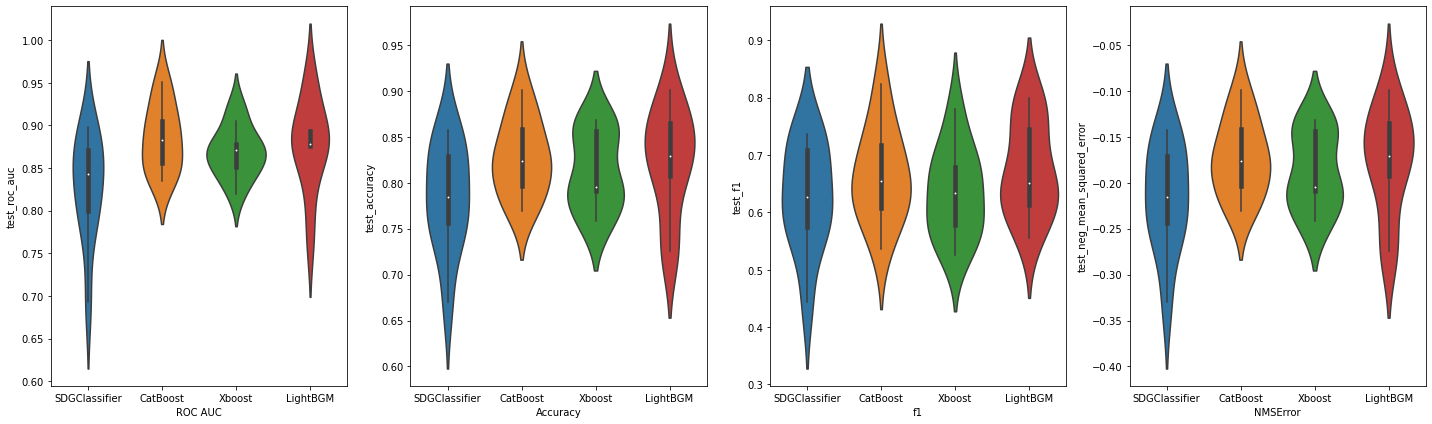

In [54]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 4)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x=model, y=roc_auc, data=df_metrics)
ax.set_xlabel("ROC AUC")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x=model, y=accuracy, data=df_metrics)
ax.set_xlabel("Accuracy")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x=model, y=f1, data=df_metrics)
ax.set_xlabel("f1")

ax = fig.add_subplot(gs[0, 3])
sns.violinplot(x=model, y=neg_mean_squared_error, data=df_metrics)
ax.set_xlabel("NMSError")

fig.tight_layout()
plt.show()


In [50]:
fig.savefig('violin_models.png')

### Radar Chart